In [1]:
from datetime import datetime
import geopandas as gpd
import numpy as np
import pandas as pd
import pyarrow

In [2]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

# Load the data

In [13]:
## Read csvs
train_df = gpd.read_file('train.geojson', index_col=0)
test_df = gpd.read_file('test.geojson', index_col=0)

In [3]:
train_df.to_parquet('train.parquet', engine = 'pyarrow')
test_df.to_parquet('test.parquet', engine = 'pyarrow')

NameError: name 'train_df' is not defined

In [4]:
## Read csvs
train_df = gpd.read_parquet('train.parquet')
test_df = gpd.read_parquet('test.parquet')

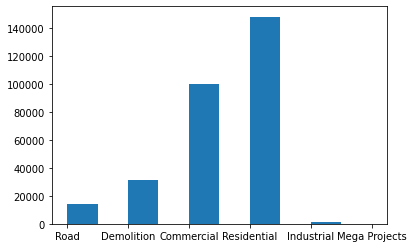

In [5]:
from matplotlib import pyplot as plt
plt.hist(train_df['change_type'])
plt.show()


In [6]:
def Convert_date(x):
    if pd.isna(x):
        return pd.NaT
    try:
        return datetime.strptime(str(x), '%d-%m-%Y').date()
    except (ValueError, TypeError):
        return pd.NaT

In [7]:
def Format_data(df : gpd.GeoDataFrame) -> pd.DataFrame :
    """fomrmat the geopandas dataframe to a correct dataframe with one hoit encoded columns and normalized values

    Args:
        df (gpd.GeoDataFrame): The geopandas dataframe to format

    Returns:
        pd.DataFrame: The correct formated dataframe
    """
    #Convert urban types and geography types to one hot by hand, because mixed values are possible
    urban_types = df['urban_type'].str.split(',', expand = True)
    geography_types = df['geography_type'].str.split(',', expand = True)

    unique_urban_types = set(urban_types.values.flatten()) - {None}
    unique_geography_types = set(geography_types.values.flatten()) - {None}
    one_hot_encoded = pd.DataFrame(index=df.index)

    for urban_type in unique_urban_types:
        one_hot_encoded[urban_type] = urban_types.apply(lambda row: 1 if urban_type in row.values else 0, axis=1)

    for geography_type in unique_geography_types:
        one_hot_encoded[geography_type] = geography_types.apply(lambda row: 1 if geography_type in row.values else 0, axis=1)
    
    df_oh = pd.concat([df, one_hot_encoded], axis=1)
    df_oh = df_oh.drop(['urban_type', 'geography_type'], axis = 1)

    #one hot encode other categorical columns
    df_oh = pd.get_dummies(df_oh,columns=['change_status_date0',
    'change_status_date1', 'change_status_date2', 'change_status_date3',
    'change_status_date4'])

    #convert the geometry in intersting features
    df_oh.loc[:,'area'] = df_oh[['geometry']].area
    df_oh.loc[:,'length'] = df_oh[['geometry']].length

    df_oh = df_oh.drop(['N', 'A', 'geometry', 'index'], axis = 1)

    return df_oh

In [8]:
def Normalize(df_oh, columns) :
    df_oh.loc[:,columns] = (df_oh.loc[:,columns] - df_oh.loc[:,columns].mean())/(df_oh.loc[:,columns].std())
    return df_oh

In [9]:
train_df_oh, test_df_oh = Format_data(train_df), Format_data(test_df)

C:\Users\emili\AppData\Local\Temp\ipykernel_14420\1981067603.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'area'] = df_oh[['geometry']].area
C:\Users\emili\AppData\Local\Temp\ipykernel_14420\1981067603.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'length'] = df_oh[['geometry']].length
C:\Users\emili\AppData\Local\Temp\ipykernel_14420\1981067603.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'area'] = df_oh[['geometry']].area
C:\Users\emili\AppData\Local\Temp\ipykernel_14420\1981067603.py:34: UserWarning: Geometry is in a ge

In [10]:
def Set_dif_date_columns(df) :
    df = df.fillna(0)
    df.loc[:,'date0'] = pd.to_datetime(df['date0'].apply(Convert_date))
    df.loc[:,'date1'] = pd.to_datetime(df['date1'].apply(Convert_date))
    df.loc[:,'date2'] = pd.to_datetime(df['date2'].apply(Convert_date))
    df.loc[:,'date3'] = pd.to_datetime(df['date3'].apply(Convert_date))
    df.loc[:,'date4'] = pd.to_datetime(df['date4'].apply(Convert_date))

    dif1 = []
    dif2 = []
    dif3 = []
    dif4 = []

    for _,dates in df.loc[:,['date0', 'date1', 'date2', 'date3', 'date4']].iterrows():
        dif1.append((dates['date1'] - dates['date0']).days)
        dif2.append((dates['date2'] - dates['date1']).days)
        dif3.append((dates['date3'] - dates['date2']).days)
        dif4.append((dates['date4'] - dates['date3']).days)
    
    df.loc[:,'date_dif1'] = dif1
    df.loc[:,'date_dif2'] = dif2
    df.loc[:,'date_dif3'] = dif3   
    df.loc[:,'date_dif4'] = dif4  
    df = df.fillna(0)
    df = df.drop(['date0', 'date1', 'date2', 'date3','date4'], axis = 1)

    return df


In [11]:
train, test = Set_dif_date_columns(train_df_oh), Set_dif_date_columns(test_df_oh)

# Outlier study

In [65]:
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay

[]

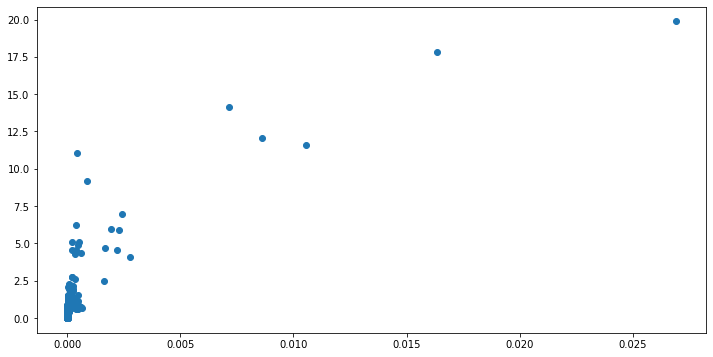

In [78]:
plt.scatter(train['area'], train['length'])
plt.plot()

In [152]:
clf = IsolationForest(max_samples = 1000)

In [ ]:
y = clf.fit_predict(train_df_oh.loc[:,['area','length']])
print(len(train_df_oh.loc[np.where(y == -1)[0], 'length']))
plt.figure(figsize = (20,20))

plt.scatter(train_df_oh.loc[np.where(y == -1)[0], 'area'],train_df_oh.loc[np.where(y == -1)[0], 'length'], c = 'r', label = 'outlier')
plt.scatter(train_df_oh.loc[np.where(y != -1)[0], 'area'],train_df_oh.loc[np.where(y != -1)[0], 'length'], c = 'b', label = 'inlier')
plt.legend()
plt.show()



In [155]:
train_df_oh_reduced = train_df_oh.loc[np.where(y != -1)[0]]

In [ ]:
plt.scatter(train_df_oh_reduced['length'],train_df_oh_reduced['area'], c = train_df_oh_reduced['change_type'].apply(lambda x: change_type_map[x]))
plt.show()

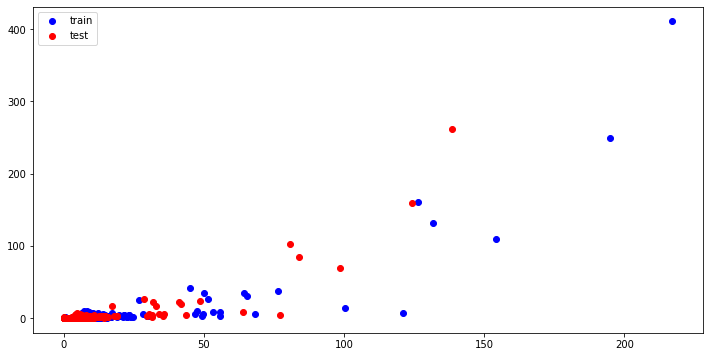

In [420]:
plt.scatter(train_df_oh['length'],train_df_oh['area'], c = 'b', label = 'train')
plt.legend()
plt.show()

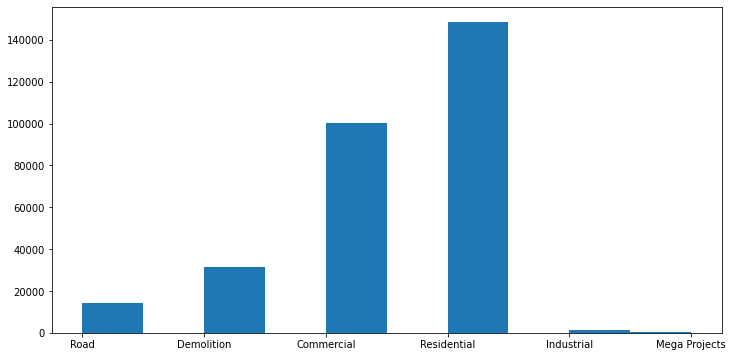

In [421]:
plt.hist(train_df_oh['change_type'])
plt.show()

In [159]:
print(test_df_oh.shape)
train_df_oh = train_df_oh.dropna(axis = 0)
test_df_oh = test_df_oh.dropna(axis = 0)
print(test_df_oh.shape)

(120526, 107)
(120526, 107)


# Other feature formating

In [12]:
from sklearn.utils import shuffle

In [13]:
train.loc[:,'change_type'] = train['change_type'].apply(lambda x: change_type_map[x])

Big inequalities in the number of samaples in the classes -> The accuracy of the models will be mainly bounded by the ratios of classes 2 and 3.
We will take only the number of samples of the class 1 (around 7000 samples), and drop the class 4 and five because their aren't enough examples of thoses classes

In [23]:
def Balance_data_set(df, keepMinorities = False) -> pd.DataFrame:
    if keepMinorities :
        classes_to_keep = [0,1,2,3]
        
    else :
        classes_to_keep = [0,1,2,3,4,5]

    df = df.loc[df['change_type'].isin(classes_to_keep)] #we keep classes 0 to 3
    # numb_per_class = len(df.loc[df['change_type'] == 1])
    numb_per_class = 70000
    df_balanced = pd.DataFrame()
    for i in classes_to_keep :
        df_class = df.loc[df['change_type'] == i]
        df_class_ = pd.DataFrame()
        if numb_per_class>len(df_class) :
            for _ in range(int(numb_per_class/len(df_class))):
                df_class_ = pd.concat([df_class_,df_class])

        else:
            df_class_ = df_class.sample(n=min(numb_per_class, len(df_class)))
            
        df_balanced = pd.concat([df_balanced,df_class_])

    df_balanced = shuffle(df_balanced).reset_index()
    df_balanced = df_balanced.drop(['index'], axis = 1)

    return df_balanced


In [24]:
train_balanced = Balance_data_set(train, keepMinorities = True)

In [25]:
features_to_drop = ['Snow', 'length', 'area']

In [26]:
train_balanced = train_balanced.drop(features_to_drop, axis = 1)
test = test.drop(features_to_drop, axis = 1)

KeyError: "['Snow', 'length', 'area'] not found in axis"

In [27]:
columns_to_normalize = ['img_red_mean_date1', 'img_green_mean_date1',
       'img_blue_mean_date1', 'img_red_std_date1', 'img_green_std_date1',
       'img_blue_std_date1', 'img_red_mean_date2', 'img_green_mean_date2',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_mean_date3', 'img_green_mean_date3',
       'img_blue_mean_date3', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5',  'date_dif1', 'date_dif2',
       'date_dif3', 'date_dif4']

In [28]:
norm_train_balanced = Normalize(train_balanced,columns_to_normalize)
norm_test = Normalize(test,columns_to_normalize)

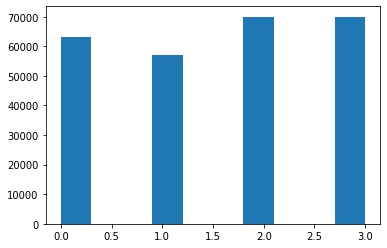

(260238, 100)


In [29]:
plt.hist(norm_train_balanced['change_type'])
plt.show()
print(norm_train_balanced.shape)

# Feature analysis

In [30]:
norm_train_balanced.shape

(260238, 100)

## Feature plots and distribution

In [31]:
norm_train_balanced.columns


Index(['change_type', 'img_red_mean_date1', 'img_green_mean_date1',
       'img_blue_mean_date1', 'img_red_std_date1', 'img_green_std_date1',
       'img_blue_std_date1', 'img_red_mean_date2', 'img_green_mean_date2',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_mean_date3', 'img_green_mean_date3',
       'img_blue_mean_date3', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5', 'Industrial', 'Rural', 'Urban Slum',
       'Dense Urban', 'Sparse Urban', 'Sparse Forest', 'Grass Land', 'River',
       'Barren Land', 'Lakes', 'Hills', 'Coastal', 'Dense Forest', 'Farms',
       'Desert', 'change_status_date0_Cons

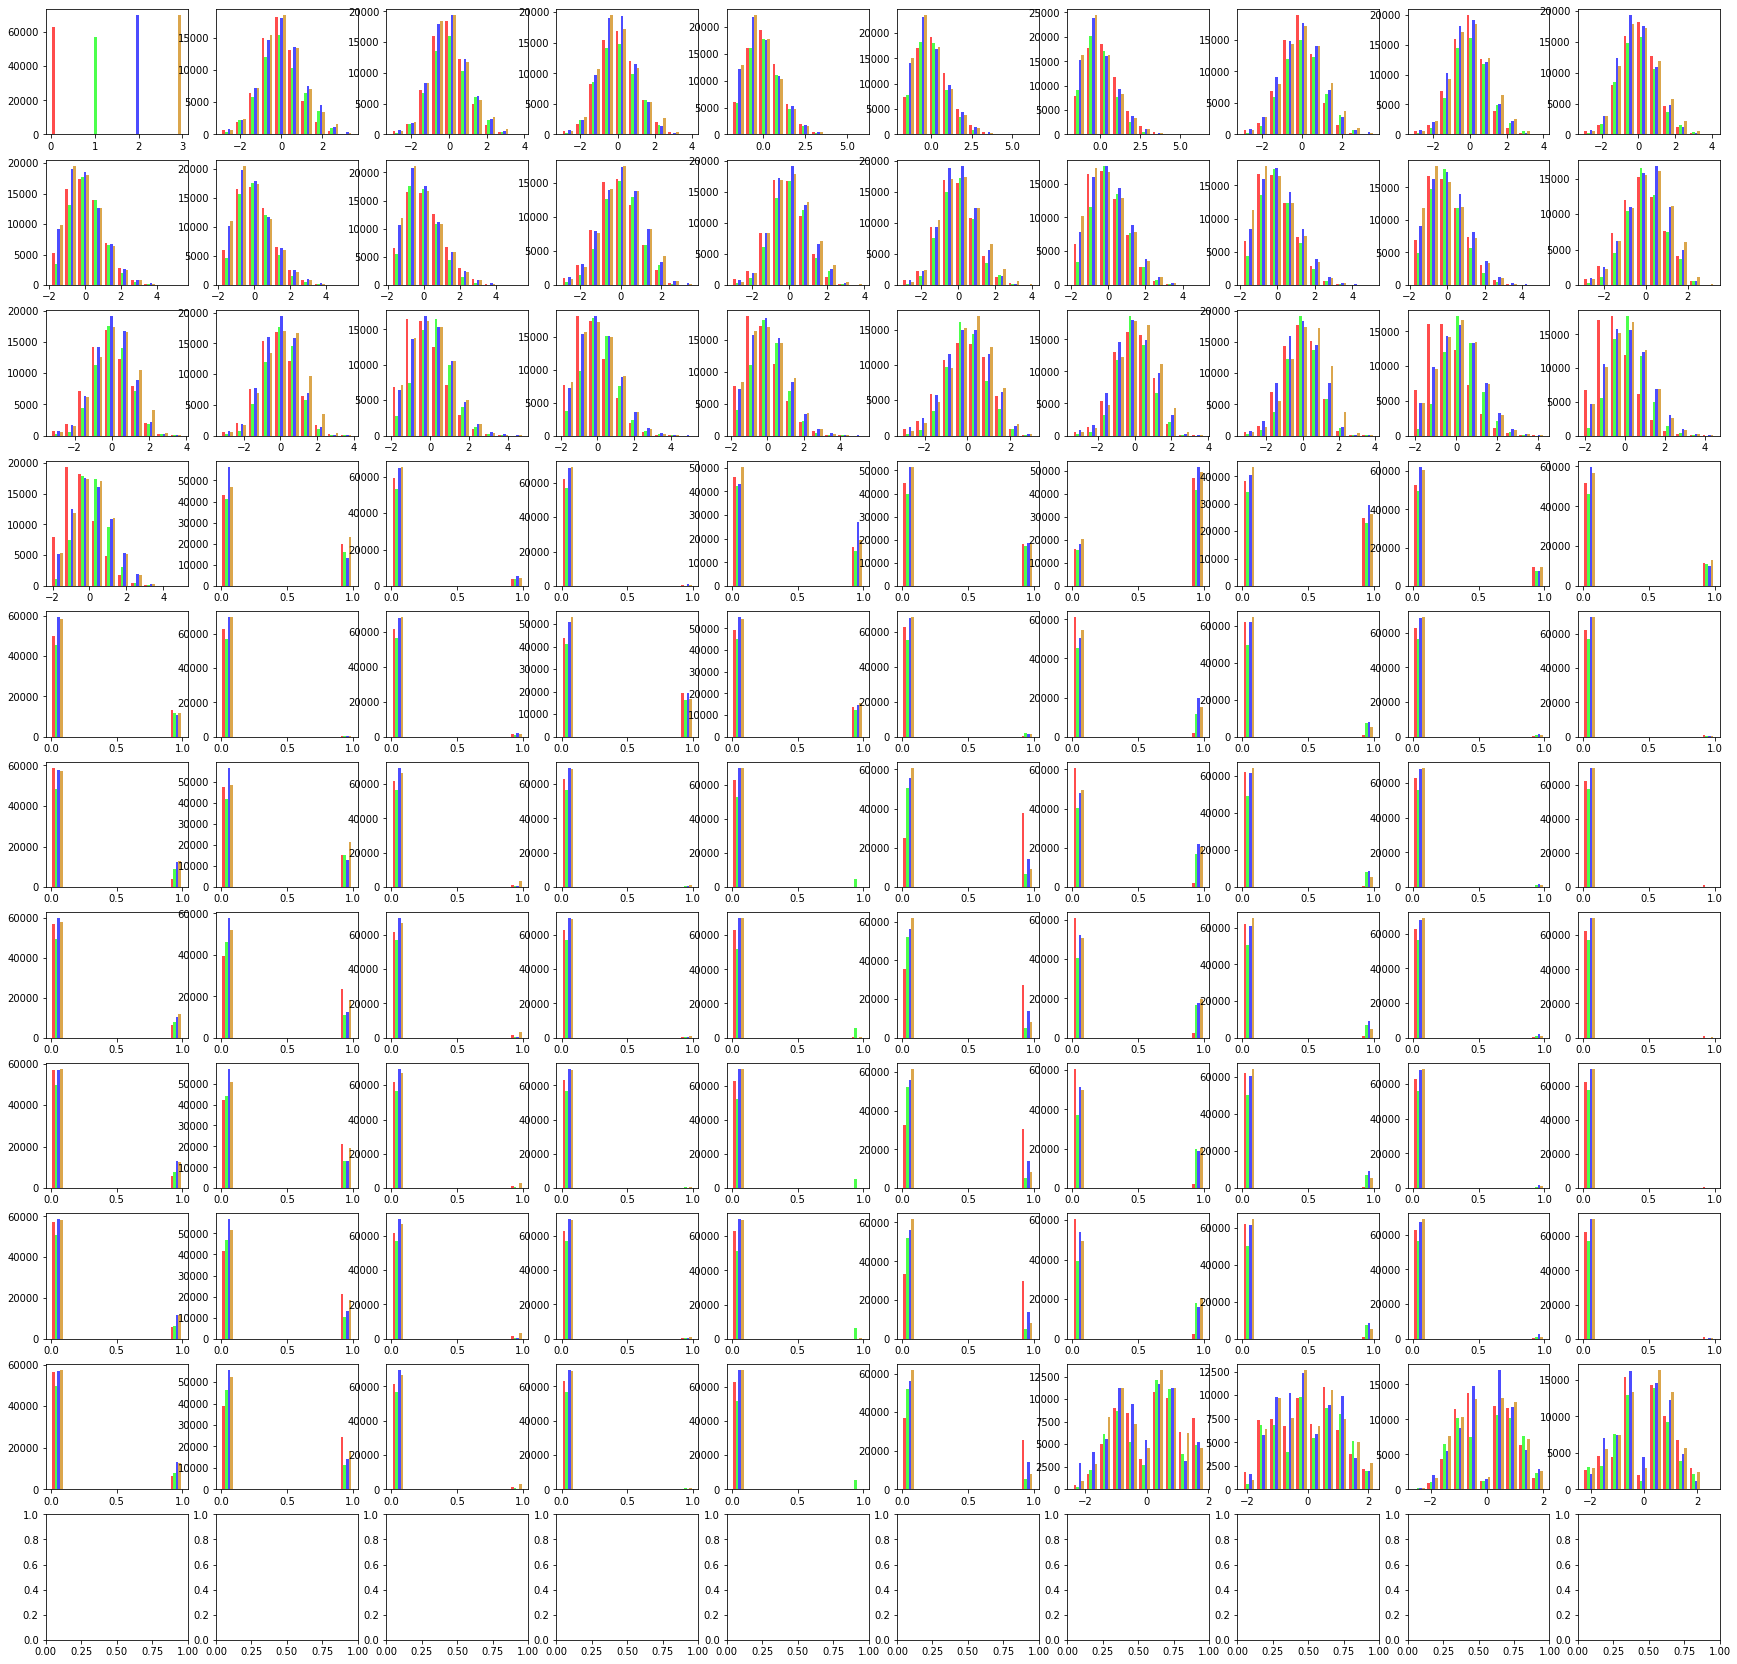

In [32]:
fig,axs = plt.subplots(11, 10, figsize = (30,30))
for i, ax in enumerate(axs.flat[:norm_train_balanced.shape[1]]):
    hists = [np.array(norm_train_balanced.loc[norm_train_balanced['change_type'] == c,norm_train_balanced.columns[i]], dtype=np.float32) for c in range(0,4)]
    ax.hist(hists,color = [[1,0,0,0.7],[0,1,0,0.7],[0,0,1,0.7],[0.8,0.5,0,0.7]])
plt.show()

In [280]:
threshold = 0.1
features_to_remove = []
for column in norm_train_balanced.columns :
    if column not in columns_to_normalize :
        # print(column, norm_train_balanced[column].sum()/len(norm_train_balanced))
        if norm_train_balanced[column].sum() < threshold * len(norm_train_balanced) :
            features_to_remove.append(column)
        

norm_train_balanced = norm_train_balanced.drop(features_to_remove, axis = 1)

In [33]:
print(norm_train_balanced.shape)

(260238, 100)


## Dimensionality reduction : PCA

In [36]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [30]:
N_COMP = norm_train_balanced.shape[1]

In [31]:
pca = PCA(n_components = N_COMP)
pca.fit(norm_train_balanced)

PCA(n_components=100)

[0.24874013 0.40001409 0.47469847 0.52328839 0.56959136 0.61143606
 0.64660892 0.6804607  0.7116884  0.74100974 0.76861819 0.79519148
 0.81942077 0.83412652 0.84744452 0.85713503 0.86493334 0.87258319
 0.87953918 0.8860247  0.89220753 0.89820852 0.90343696 0.90839273
 0.91310711 0.91771289 0.92205274 0.9263634  0.93058394 0.9342293
 0.93749546 0.94062368 0.94365391 0.94649017 0.94923223 0.95185664
 0.95430413 0.95671373 0.9590302  0.96121048 0.96330702 0.96539467
 0.96740433 0.96935436 0.97121901 0.97301951 0.97469806 0.97625571
 0.97775164 0.97915999 0.98046631 0.98170049 0.98292663 0.98403159
 0.98511138 0.98615964 0.98715262 0.98806865 0.98890891 0.98961033
 0.99017495 0.99072338 0.99123992 0.99175204 0.992256   0.99275255
 0.99322502 0.9935993  0.99396813 0.99433613 0.99469698 0.99504986
 0.99539234 0.99573069 0.99605583 0.99637292 0.99666971 0.99696129
 0.99722828 0.9974758  0.99771281 0.99793316 0.99815022 0.99835267
 0.99854362 0.99872975 0.99891206 0.99908753 0.99925468 0.99941

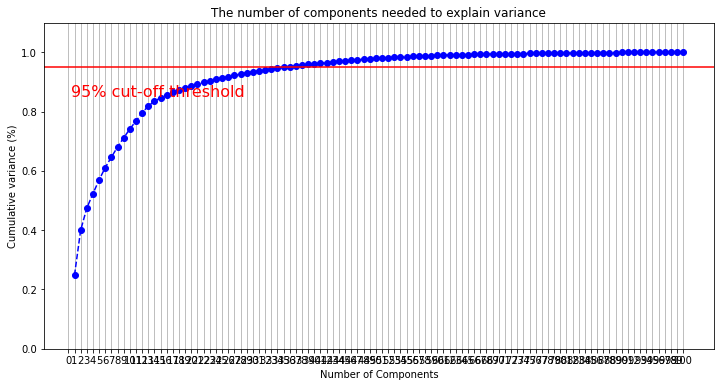

In [32]:

# matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, N_COMP + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
print(y)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, N_COMP + 1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [37]:
def Reduce_features(df, pca = None, keepBestFeatures = False, threshold = 0.1) :
    if(keepBestFeatures) :
        corr_matrix = df.corr().abs()
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

        target_cor_raw = pd.DataFrame(corr_matrix.loc['change_type']).sort_values(by='change_type', axis = 0)
        best_features = target_cor_raw.loc[target_cor_raw['change_type'] > threshold]
        print(f"The best features kept are: {best_features}")
        df = df.loc[:,best_features.index]
    
    if(pca) :
        df = pca.fit_transform(df)
    
    print(f"Number of features: {df.shape[1]}\n Number of samples: {df.shape[0]}")
    return df   

(57220, 65)


The best features kept are:                                         change_type
date_dif4                                  0.021666
img_green_std_date3                        0.023820
img_red_std_date3                          0.024948
img_blue_std_date3                         0.025086
Sparse Forest                              0.026052
...                                             ...
change_status_date1_Prior Construction     0.236008
change_status_date3_Prior Construction     0.259103
change_status_date2_Prior Construction     0.263913
change_status_date0_Prior Construction     0.340792
change_type                                1.000000

[88 rows x 1 columns]
Number of features: 88
 Number of samples: 260238


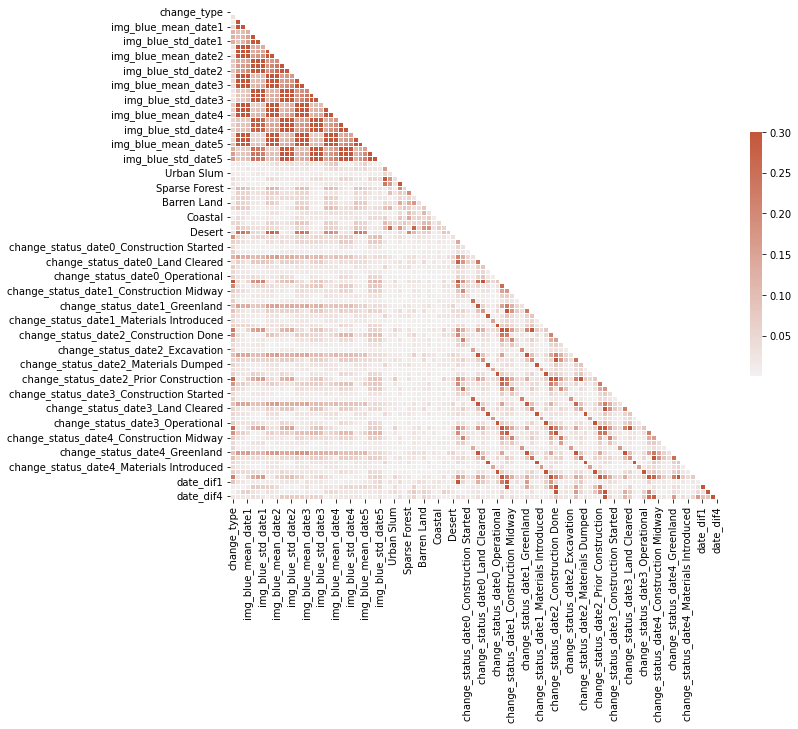

In [38]:
norm_train_reduced = Reduce_features(norm_train_balanced, keepBestFeatures=True, threshold=0.02)
norm_test_reduced = norm_test.loc[:,norm_train_reduced.drop('change_type', axis = 1).columns]

In [39]:
norm_train_reduced.shape

(260238, 88)

# Data split

In [40]:
train_df_X = norm_train_reduced.drop(['change_type'], axis = 1)
train_df_Y = norm_train_reduced['change_type']

In [41]:
train_X, train_Y = np.asarray(train_df_X, dtype = np.float32), np.asarray(train_df_Y, dtype= np.int32)

In [42]:
#Simple split
#TODO : Implement cross validation for the training and validation

split_ratio = 0.8

train_x, val_x = train_X[:int(len(train_X)*split_ratio)], train_X[int(len(train_X)*split_ratio):]
train_y, val_y = train_Y[:int(len(train_X)*split_ratio)], train_Y[int(len(train_X)*split_ratio):]

In [43]:
print(train_x.shape)
print(val_x.shape)

(208190, 87)
(52048, 87)


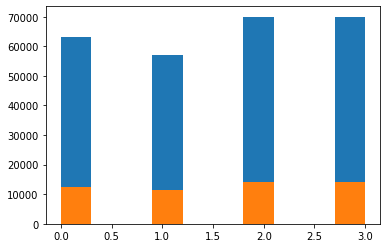

In [44]:
plt.hist(train_Y, label = 'Train')
plt.hist(val_y,label='Validation')
plt.show()

# First model

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tqdm import tqdm

In [49]:
accuracies = []
for neighbors in tqdm(range(2,51)) : 
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    neigh.fit(train_x, train_y)
    pred_y = neigh.predict(val_x)
    accuracies.append(accuracy_score(val_y, pred_y))

100%|██████████| 49/49 [10:10<00:00, 12.46s/it]


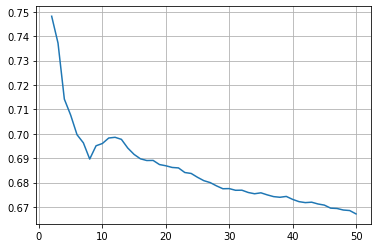

Best accuracie achieved : 0.7481555487242545


In [51]:
plt.plot(range(2,51), accuracies)

plt.grid(True)
plt.show()

print(f"Best accuracie achieved : {max(accuracies)}")


Best accuracy : 0.61

In [52]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(train_x, train_y)
pred_y = neigh.predict(val_x)
# acc= accuracy_score(val_y,pred_y)

In [53]:
print(confusion_matrix(val_y,pred_y))
print(f"Mean f1 score: {f1_score(val_y, pred_y, average = 'micro' )}")

[[10816   488   782   487]
 [  402  9491   758   780]
 [ 1007  1935  8974  2045]
 [ 1145  3079  3389  6470]]
Mean f1 score: 0.6868851829080849


# Second model

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [262]:
decTree = DecisionTreeClassifier()
decTree.fit(train_x, train_y)
pred_y = decTree.predict(val_x)
print(accuracy_score(val_y, pred_y))

0.592820816403412


# Third model

In [263]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
accuracies = []
randFor = GradientBoostingClassifier()
randFor.fit(train_x, train_y)
pred_y = randFor.predict(val_x)
acc = accuracy_score(val_y, pred_y)
print(acc)
accuracies.append(acc)

Best accuracy : 0.59

# Fourth model

In [356]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
svc = SVC(gamma=2, C=1)
svc.fit(train_x, train_y)
pred_y = svc.predict(val_x)
acc = accuracy_score(val_y, pred_y)
print(acc)


Best accuracy :

# Neural network

In [55]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device('cpu')
print(torch.cuda.is_available())

True


In [56]:
class SimpleNN(nn.Module):
    def __init__(self,n_input,n_neurones):
        super(SimpleNN,self).__init__()
        self.layer1 = nn.Linear(n_input,n_neurones)
        self.layer2 = nn.Linear(n_neurones, int(n_neurones/3))
        self.layer3 = nn.Linear(int(n_neurones/3),6)
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [57]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for x, labels in torch.utils.data.DataLoader(data, batch_size=64):
        x = x.to(device)
        labels = labels.to(device)
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).cpu().detach().sum().item()
        total += x.cpu().detach().shape[0]
    return correct / total
  


In [58]:
def train(model, train_data, val_data, batch_size=64, num_epochs=1 , print_stat = 1):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
    # criterion = nn.MultiMarginLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00002)
    # scheduler = lr_scheduler.LinearLR(optimizer,start_factor=1.0, end_factor=0.005, total_iters=num_epochs/2)


    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for x, labels in iter(train_loader):
            x = x.to(device)
            labels = labels.to(device)
            out = model(x)            
            loss = criterion(out, labels)
            
            loss.backward()               
            
            optimizer.step()
                      
            optimizer.zero_grad()         

            # save the current training information
            iters.append(n)
            train_loss = float(loss.cpu().detach())/batch_size
                     
            n += 1
        losses.append(train_loss)    
        train_accu,val_accu = get_accuracy(model, train_data),get_accuracy(model, val_data)
        train_acc.append(train_accu) # compute training accuracy 
        val_acc.append(val_accu)  # compute validation accuracy

        # scheduler.step()
        lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch}, Train Loss: {train_loss}, Train accuracy: {train_accu}, Validation accuracy: {val_accu}, Learning rate: {lr}")

    if print_stat:
      # plotting
      plt.title("Training Curve")
      plt.plot(range(num_epochs), losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_acc, label="Train")
      plt.plot(range(num_epochs), val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))
      print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    
    
print('done')

done


In [208]:
split_ratio = 0.8

train_x, val_x = train_X[:int(len(train_X)*split_ratio)], train_X[int(len(train_X)*split_ratio):]
train_y, val_y = train_Y[:int(len(train_X)*split_ratio)], train_Y[int(len(train_X)*split_ratio):]

In [73]:
model = SimpleNN(train_x.shape[1], 200)
model = model.to(device)

In [60]:
train_x.shape
model

SimpleNN(
  (layer1): Linear(in_features=87, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=33, bias=True)
  (layer3): Linear(in_features=33, out_features=6, bias=True)
)

In [61]:
train_x = np.array(train_x, dtype = np.float32)
val_x = np.array(val_x, dtype = np.float32)

In [62]:
X = torch.Tensor(train_x)
Y=torch.Tensor(train_y)
Y = Y.type(torch.LongTensor)
train_data = data_utils.TensorDataset(X,Y)

X_ = torch.Tensor(val_x)
Y_=torch.Tensor(val_y)
Y_ = Y_.type(torch.LongTensor)
val_data = data_utils.TensorDataset(X_,Y_)


Epoch 0, Train Loss: 0.006719748179117839, Train accuracy: 0.43726403765790867, Validation accuracy: 0.4346564709498924, Learning rate: 2e-05
Epoch 1, Train Loss: 0.0057651083916425705, Train accuracy: 0.5183150007204957, Validation accuracy: 0.5152935751613895, Learning rate: 2e-05
Epoch 2, Train Loss: 0.005275929346680641, Train accuracy: 0.5475671261828138, Validation accuracy: 0.5424415923762681, Learning rate: 2e-05
Epoch 3, Train Loss: 0.005535619333386421, Train accuracy: 0.565800470723858, Validation accuracy: 0.5596756839840148, Learning rate: 2e-05
Epoch 4, Train Loss: 0.005530776455998421, Train accuracy: 0.5796820212306066, Validation accuracy: 0.5737588379956963, Learning rate: 2e-05
Epoch 5, Train Loss: 0.004775544938941796, Train accuracy: 0.5912627887986935, Validation accuracy: 0.584767906547802, Learning rate: 2e-05
Epoch 6, Train Loss: 0.004771392792463303, Train accuracy: 0.6027426869686344, Validation accuracy: 0.5967760528742699, Learning rate: 2e-05
Epoch 7, Trai

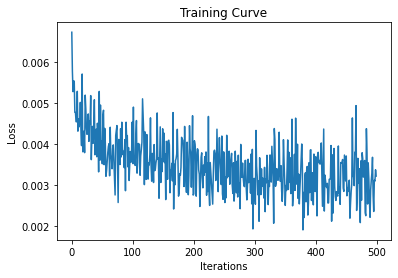

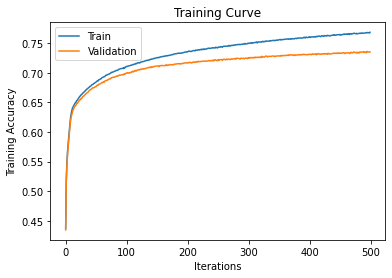

Final Training Accuracy: 0.7682309428887074
Final Validation Accuracy: 0.735013833384568


In [74]:
train(model, train_data = train_data, val_data = val_data, num_epochs = 500, batch_size = 192)

In [75]:
pred_y = []

for x, labels in torch.utils.data.DataLoader(val_data, batch_size=1):
    with torch.no_grad():
        model = model.cpu()
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        pred_y.append(pred.item())

pred_y = np.array(pred_y)

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

print(confusion_matrix(val_y,pred_y))
print(f"Mean f1 score: {f1_score(val_y, pred_y, average = 'macro' )}")

[[11778   144   198   453]
 [   89  9300   756  1286]
 [  743  1273  8857  3088]
 [  655  1837  3270  8321]]
Mean f1 score: 0.7383404903778896


# Test and create submission

In [71]:
train_x.shape

(208190, 87)

In [77]:
X = torch.Tensor(np.array(norm_test_reduced, dtype=np.float32))
preds = []
for x in X:
    with torch.no_grad():
        model = model.cpu()
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(0, keepdim=True)[1]
        preds.append(pred.item())
submission_df = pd.DataFrame({'change_type': preds})
submission_df.to_csv("nn_submission.csv", index=True, index_label='Id')
